# Solución etapa 4 - Training - Predict - Fallos v1

In [30]:
# Utilidades para print
from utils.print_utils import tabl, headr, titl
from utils.explore_utils import explr

In [31]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_validate
from utils.best_model_utils import cv_train, generate_learning_curves, generate_validation_curves

from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster


In [32]:
version_to_load = 'v1'

In [33]:
# Cargar el dataset
csv_path = f'../data/preprocessed/preprocessed_data_{version_to_load}.csv'
print('... Loading:', csv_path, '...')
final_data = pd.read_csv(csv_path)

tabl(final_data)

... Loading: ../data/preprocessed/preprocessed_data_v1.csv ...
      ID_Equipo  Fecha         Temperatura_C    Vibracion_mm_s    Horas_Operativas    Fallo  Tipo_Equipo    Fabricante    Modelo      Potencia_kW    Horas_Recomendadas_Revision
--  -----------  ----------  ---------------  ----------------  ------------------  -------  -------------  ------------  --------  -------------  -----------------------------
 0            1  2021-01-01          34.7499          2.13681                  614        0  Bomba          Fabricante_C  Modelo_6            173                            913
 1            1  2021-01-03          56.2006          1.52939                  658        0  Bomba          Fabricante_C  Modelo_6            173                            913
 2            1  2021-01-04          70.5556          3.41101                  664        0  Bomba          Fabricante_C  Modelo_6            173                            913
 3            1  2021-01-05          97.509         

In [34]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731749 entries, 0 to 731748
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID_Equipo                    731749 non-null  int64  
 1   Fecha                        731749 non-null  object 
 2   Temperatura_C                731749 non-null  float64
 3   Vibracion_mm_s               731749 non-null  float64
 4   Horas_Operativas             731749 non-null  int64  
 5   Fallo                        731749 non-null  float64
 6   Tipo_Equipo                  731749 non-null  object 
 7   Fabricante                   731749 non-null  object 
 8   Modelo                       731749 non-null  object 
 9   Potencia_kW                  731749 non-null  int64  
 10  Horas_Recomendadas_Revision  731749 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 61.4+ MB


In [35]:
target_forecast_column = 'Horas_Operativas'
target_class_column = 'Fallo'

In [36]:
# Steps y lags
steps = 15
lags = 50

## Funciones procesado

In [37]:
# Preparar el dataset

def prep_equipo(equipo):
    equipo.drop(columns=['ID_Equipo', 'Tipo_Equipo', 'Modelo', 'Potencia_kW',
                'Horas_Recomendadas_Revision', 'Fabricante'], inplace=True)

    equipo['Fecha'] = pd.to_datetime(equipo['Fecha'], format='%Y-%m-%d')

    # fecha como índice
    equipo = equipo.set_index('Fecha')

    # Eliminar índices duplicados (mantener el primero)
    equipo_clean = equipo[~equipo.index.duplicated(keep='first')]
    equipo_clean[equipo_clean.index.duplicated()]

    # Convierte Timeseries a frecuencia especificada.
    equipo_fq = equipo_clean.asfreq('D')

    equipo_fq.fillna(equipo_clean.median(), inplace=True)

    # print(equipo_fq.info())

    return equipo_fq

In [38]:
# Separación datos train-test

def sep_train_test(equipo_fq, steps, doPlot=True):
    steps = steps
    datos_train = equipo_fq[:-steps]
    datos_test = equipo_fq[-steps:]
    # print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
    # print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

    if (doPlot):
        fig, ax = plt.subplots(figsize=(16, 5))
        datos_train['Horas_Operativas'].plot(ax=ax, label='train')
        datos_test['Horas_Operativas'].plot(ax=ax, label='test')
        ax.legend()

    return datos_train, datos_test

In [39]:
# Generar modelo final

def gen_finalModel(steps, best_lags, best_params, datos_train, exogs_train, target_column):
    # Crear y entrenar forecaster final
    forecaster = ForecasterRecursive(
        regressor=Ridge(alpha=best_params['alpha'], random_state=123),
        transformer_y=StandardScaler(),
        lags=best_lags
    )

    forecaster.fit(y=datos_train[target_column], exog=exogs_train)

    return forecaster

In [40]:
# Evaluar error

def get_error(target_column, predicciones, equipo_fq, datos_test):
    # Error test
    error_mse = mean_squared_error(
        y_true=datos_test[target_column],
        y_pred=predicciones
    )

    data_var = equipo_fq[target_column].var()

    mse2var = round(error_mse/data_var*100, 2)

    print(f"Error de test (mse): {error_mse}")
    print(f"Varianza datos: {data_var}")
    print(f"mse2var: {mse2var}%")

    return mse2var

## Un equipo

In [41]:
eq = 1

best_lags = 50
best_params = {'alpha': 0.1}

In [42]:
# Filtrar el df del equipo
equipo = final_data[final_data['ID_Equipo'] == eq].copy()

# Preparar el dataset para el equipo seleccionado
equipo_fq = prep_equipo(equipo)

equipo_fq

,Temperatura_C,Vibracion_mm_s,Horas_Operativas,Fallo
Fecha,,,,
2021-01-01,34.749896,2.136812,614.0,0.0
2021-01-02,59.465745,5.133322,172.5,0.0
2021-01-03,56.200558,1.529395,658.0,0.0
2021-01-04,70.555608,3.411009,664.0,0.0
2021-01-05,97.509000,0.618757,683.0,0.0
...,...,...,...,...
2024-12-27,38.587761,2.748949,808.0,0.0
2024-12-28,90.397197,5.382844,812.0,0.0
2024-12-29,21.104524,5.686564,824.0,0.0


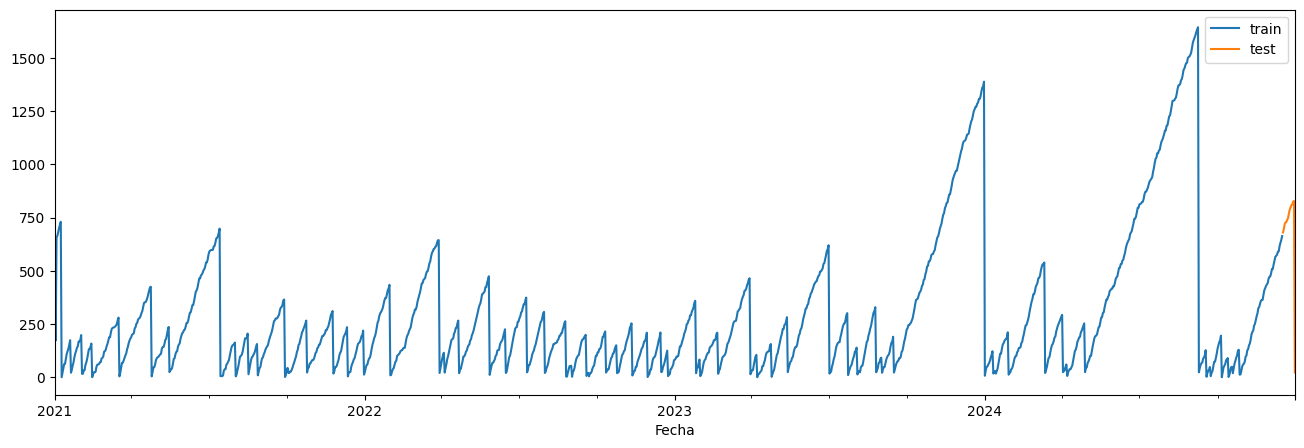

In [43]:
# train-test
train_data, test_data = sep_train_test(equipo_fq, steps, doPlot=True)

In [44]:
# Exógenos para el modelo
exogs = equipo_fq.drop(columns=target_forecast_column)
exogs_train = equipo_fq.drop(columns=target_forecast_column)[:-steps]
exogs_test = equipo_fq.drop(columns=target_forecast_column)[-steps:]

In [45]:
exogs[:-steps]

,Temperatura_C,Vibracion_mm_s,Fallo
Fecha,,,
2021-01-01,34.749896,2.136812,0.0
2021-01-02,59.465745,5.133322,0.0
2021-01-03,56.200558,1.529395,0.0
2021-01-04,70.555608,3.411009,0.0
2021-01-05,97.509000,0.618757,0.0
...,...,...,...
2024-12-12,47.524678,0.731239,0.0
2024-12-13,48.043295,8.836478,0.0
2024-12-14,72.829938,0.553675,0.0


In [46]:
# modelo final
final_model = gen_finalModel(steps, best_lags, best_params, equipo_fq[:-steps], exogs_train, target_forecast_column)

# Predicciones
predicciones = final_model.predict(steps=steps, exog=exogs_test)
predicciones.shape

(15,)

In [47]:
# Backtesting

cv = TimeSeriesFold(
    steps=steps,
    initial_train_size=lags+1,
    fixed_train_size=False,
    refit=True,
)

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster=final_model,
    y=equipo_fq[target_forecast_column],
    cv=cv,
    metric='mean_squared_error',
    verbose=True
)

print('metrica:\n', metrica)

Information of folds
--------------------
Number of observations used for initial training: 51
Number of observations used for backtesting: 1410
    Number of folds: 94
    Number skipped folds: 0 
    Number of steps per fold: 15
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2021-01-01 00:00:00 -- 2021-02-20 00:00:00  (n=51)
    Validation: 2021-02-21 00:00:00 -- 2021-03-07 00:00:00  (n=15)
Fold: 1
    Training:   2021-01-01 00:00:00 -- 2021-03-07 00:00:00  (n=66)
    Validation: 2021-03-08 00:00:00 -- 2021-03-22 00:00:00  (n=15)
Fold: 2
    Training:   2021-01-01 00:00:00 -- 2021-03-22 00:00:00  (n=81)
    Validation: 2021-03-23 00:00:00 -- 2021-04-06 00:00:00  (n=15)
Fold: 3
    Training:   2021-01-01 00:00:00 -- 2021-04-06 00:00:00  (n=96)
    Validation: 2021-04-07 00:00:00 -- 2021-04-21 00:00:00  (n=15)
Fold: 4
    Training:   2021-01-01 00:00:00 -- 2021-04-21 00:00:00  (n=111)
    Validation: 2021-04-22 

d:\Program Files\Python\Python312\Lib\site-packages\skforecast\model_selection\_validation.py:185: LongTrainingWarning: The forecaster will be fit 94 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

metrica:
    mean_squared_error
0        46882.592164


In [48]:
print('predicciones_backtest:\n', predicciones_backtest.shape)
predicciones_backtest.head(10)


predicciones_backtest:
 (1410, 1)


,pred
2021-02-21,59.0
2021-02-22,59.0
2021-02-23,59.0
2021-02-24,59.0
2021-02-25,59.0
2021-02-26,59.0
2021-02-27,59.0
2021-02-28,59.0
2021-03-01,59.0
2021-03-02,59.0


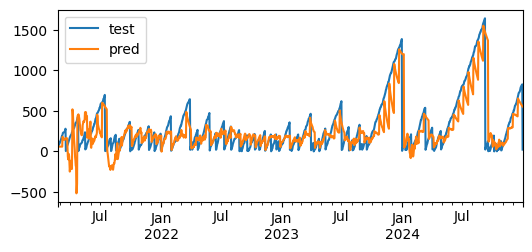

In [49]:
# Gráfico de predicciones de backtest vs valores reales

fig, ax = plt.subplots(figsize=(6, 2.5))
equipo_fq.loc[predicciones_backtest.index, target_forecast_column].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend()

In [50]:
# residuos
residuals = equipo_fq[target_forecast_column] - predicciones_backtest.pred

print(residuals.head(60), residuals.shape)

2021-01-01     NaN
2021-01-02     NaN
2021-01-03     NaN
2021-01-04     NaN
2021-01-05     NaN
2021-01-06     NaN
2021-01-07     NaN
2021-01-08     NaN
2021-01-09     NaN
2021-01-10     NaN
2021-01-11     NaN
2021-01-12     NaN
2021-01-13     NaN
2021-01-14     NaN
2021-01-15     NaN
2021-01-16     NaN
2021-01-17     NaN
2021-01-18     NaN
2021-01-19     NaN
2021-01-20     NaN
2021-01-21     NaN
2021-01-22     NaN
2021-01-23     NaN
2021-01-24     NaN
2021-01-25     NaN
2021-01-26     NaN
2021-01-27     NaN
2021-01-28     NaN
2021-01-29     NaN
2021-01-30     NaN
2021-01-31     NaN
2021-02-01     NaN
2021-02-02     NaN
2021-02-03     NaN
2021-02-04     NaN
2021-02-05     NaN
2021-02-06     NaN
2021-02-07     NaN
2021-02-08     NaN
2021-02-09     NaN
2021-02-10     NaN
2021-02-11     NaN
2021-02-12     NaN
2021-02-13     NaN
2021-02-14     NaN
2021-02-15     NaN
2021-02-16     NaN
2021-02-17     NaN
2021-02-18     NaN
2021-02-19     NaN
2021-02-20     NaN
2021-02-21     1.0
2021-02-22  

## Clasificador

In [51]:
# Ingeniería de características en residuos
def create_features(data, residuals, lags):
    features = pd.DataFrame(index=data.index)
    for lag in range(1, lags + 1):
        features[f'lag_{lag}'] = data.shift(lag)

    features['residuals'] = residuals

    features.dropna(inplace=True)

    return features

In [52]:
# Crear características

X = create_features(equipo_fq[target_class_column], residuals, lags)
y = equipo_fq[target_class_column].iloc[lags+1:]


# Agregar variables exógenas
X = pd.concat([X, exogs.iloc[lags+1:]], axis=1)

# eliminar columna de target
X.drop(columns=[target_class_column], inplace=True)

print('\nX:')
tabl(X.head(60))
print(X.shape)

print('\n---- y:')
print(y.head())
print(y.shape)


X:
Fecha                  lag_1    lag_2    lag_3    lag_4    lag_5    lag_6    lag_7    lag_8    lag_9    lag_10    lag_11    lag_12    lag_13    lag_14    lag_15    lag_16    lag_17    lag_18    lag_19    lag_20    lag_21    lag_22    lag_23    lag_24    lag_25    lag_26    lag_27    lag_28    lag_29    lag_30    lag_31    lag_32    lag_33    lag_34    lag_35    lag_36    lag_37    lag_38    lag_39    lag_40    lag_41    lag_42    lag_43    lag_44    lag_45    lag_46    lag_47    lag_48    lag_49    lag_50    residuals    Temperatura_C    Vibracion_mm_s
-------------------  -------  -------  -------  -------  -------  -------  -------  -------  -------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  -----

In [53]:
# Crear características para entrenamiento

X_train, X_test = X[:-steps], X[-steps:]
y_train, y_test = y[:-steps], y[-steps:]

print('\nTRAIN:')
tabl(X_train.head())
print(y_train.head())

print('\nTEST:')
tabl(X_test.head())
print(y_test.head())


TRAIN:
Fecha                  lag_1    lag_2    lag_3    lag_4    lag_5    lag_6    lag_7    lag_8    lag_9    lag_10    lag_11    lag_12    lag_13    lag_14    lag_15    lag_16    lag_17    lag_18    lag_19    lag_20    lag_21    lag_22    lag_23    lag_24    lag_25    lag_26    lag_27    lag_28    lag_29    lag_30    lag_31    lag_32    lag_33    lag_34    lag_35    lag_36    lag_37    lag_38    lag_39    lag_40    lag_41    lag_42    lag_43    lag_44    lag_45    lag_46    lag_47    lag_48    lag_49    lag_50    residuals    Temperatura_C    Vibracion_mm_s
-------------------  -------  -------  -------  -------  -------  -------  -------  -------  -------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  -

### Clasificador

In [54]:
# Ajustar bosque aleatorio en residuos
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [55]:
# generar predicciones

y_pred = lr_model.predict(X_test)

print(y_pred)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [56]:
# evaluar el modelo
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc}')

Accuracy: 0.9333333333333333


### Curva Validación - Curva Aprendizaje

In [100]:
from utils.temporal_vc import TemporalSplit
from sklearn.model_selection import KFold

temporal_split = TemporalSplit(test_size=steps, n_splits=40)
kf = KFold(n_splits=40, shuffle=False)

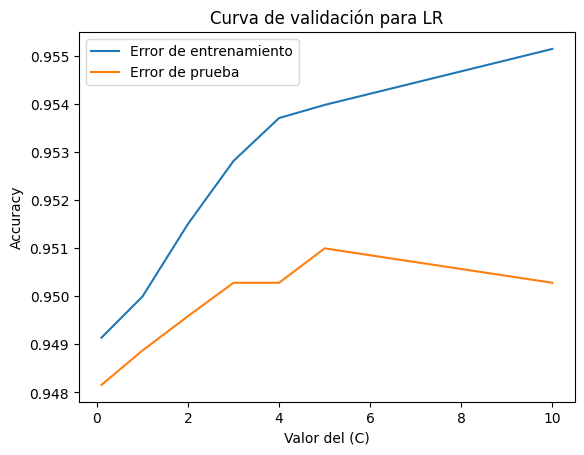

In [109]:
from sklearn.model_selection import validation_curve

Cs = [0.1, 1, 2,3,4, 5, 10]

generate_validation_curves('LR', lr_model, X, y, 'C', Cs, kf)


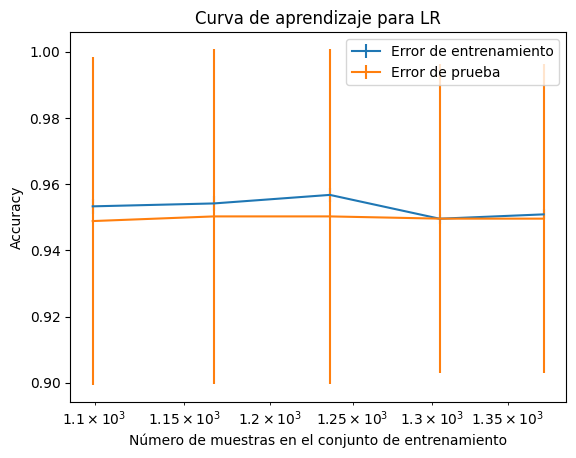

In [110]:
train_sizes = np.linspace(0.8, 1.0, num=5, endpoint=True)

generate_learning_curves('LR', lr_model, X, y, train_sizes, kf)

## Pipelines

In [79]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)


print(headr("Numerical columns"), numerical_columns)
print(headr("Categorical columns"), categorical_columns)


Numerical columns
 ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_36', 'lag_37', 'lag_38', 'lag_39', 'lag_40', 'lag_41', 'lag_42', 'lag_43', 'lag_44', 'lag_45', 'lag_46', 'lag_47', 'lag_48', 'lag_49', 'lag_50', 'residuals', 'Temperatura_C', 'Vibracion_mm_s']

Categorical columns
 []


In [111]:
# Preprocesamiento para variables categóricas
categorical_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocesamiento para variables continuas
numerical_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combinar preprocesadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

In [112]:
pipelines = {
    "LogisticRegression": Pipeline([('preprocessor', preprocessor),('classifier', LogisticRegression())]),
    "GradientBoostingClassifier": Pipeline([('preprocessor', preprocessor),('classifier', GradientBoostingClassifier())]),
    # "SVC": Pipeline([('preprocessor', preprocessor),('classifier', SVC(kernel='linear'))]),
    # "SGDClassifier": Pipeline([('preprocessor', preprocessor),('classifier', SGDClassifier())]),
}

### CV

In [113]:
# Aplicar CV
results = {}

for name, pipeline in pipelines.items():
    print(headr(f"Entrenar {name}"))
    results[name] = cv_train(name, pipeline, kf, X_train, y_train, X_test, y_test)

print(titl("Resultados:"))
results_df=pd.DataFrame(results)
tabl(results_df)


Entrenar LogisticRegression

test score (mean-std): 0.95 - 0.05
train score (mean-std): 0.96 - 0.00
params: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Entrenar GradientBoostingClassifier

test score (mean-std): 0.95 - 0.05
train score (mean-std): 0.99 - 0.00
params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

** RESULTADOS: **

       LogisticRegression    G

### Curva de aprendizaje

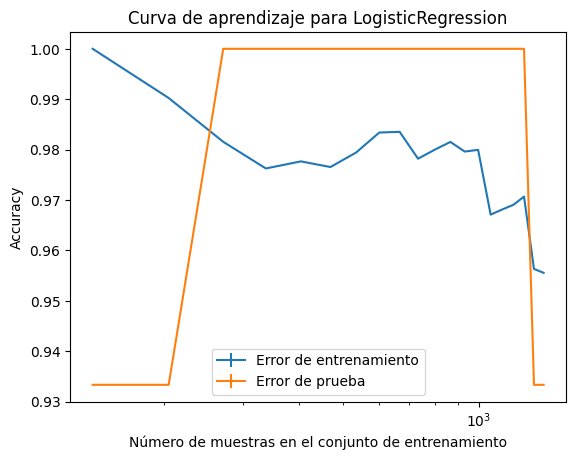

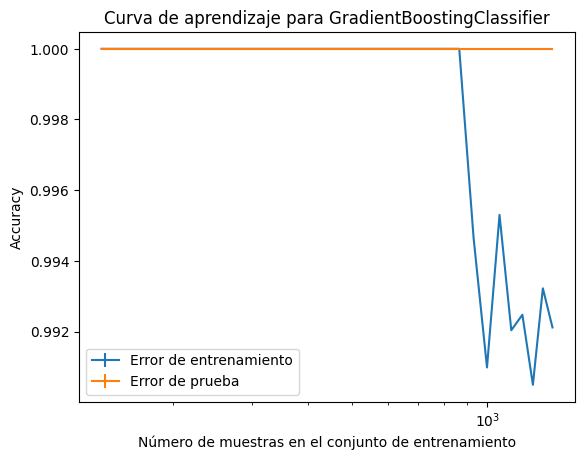

In [114]:
# Aplicar LC
train_sizes = np.linspace(0.1, 1.0, num=20, endpoint=True)

for pipeline_name, pipeline_obj in pipelines.items():
    generate_learning_curves(pipeline_name, pipeline_obj, X, y, train_sizes, temporal_split)

### Curva validación

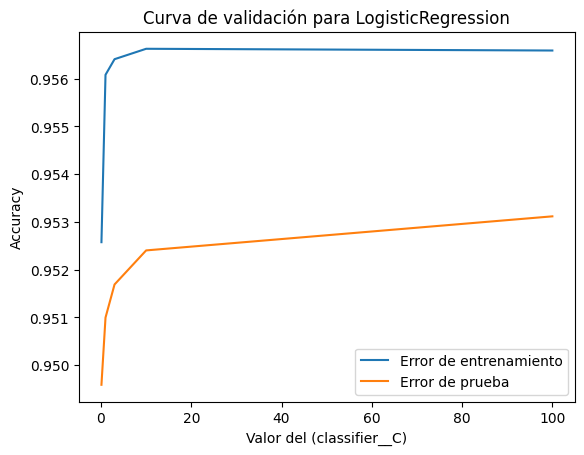

In [118]:
pname = 'LogisticRegression'
Cs = [0.1, 1,3, 10, 100]
# Cs = [5, 10, 15]
generate_validation_curves(pname, pipelines[pname], X, y, 'classifier__C', Cs, kf)

### Afinar hiperparámentros

#### LogisticRegression

In [119]:
from sklearn.model_selection import GridSearchCV

pname = 'LogisticRegression'

param_grid = {
    'classifier__C': [5, 10, 15],
    # 'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
    'classifier__solver': ['lbfgs', 'liblinear', 'newto-cg', 'newto-cholesky', 'sag', 'saga']
    # 'classifier__max_iter': [1,10,100,1000]
}

grid_search = GridSearchCV(pipelines[pname], param_grid, cv=kf, scoring="accuracy")

grid_search.fit(X_train, y_train)

print(headr(pname))
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor accuracy: {grid_search.best_score_:.2f}")

C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ricar\


LogisticRegression

Mejores hiperparámetros: {'classifier__C': 10, 'classifier__solver': 'lbfgs'}
Mejor accuracy: 0.95


C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
240 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\sk

## re-entrenar + re-evaluar

In [121]:
# Definir pipelines con mejores hiperparámetros
pipelines = {
    "LogisticRegression": Pipeline([('preprocessor', preprocessor),('classifier', LogisticRegression(C=10,solver='lbfgs'))]),
    # "GradientBoostingClassifier": Pipeline([('preprocessor', preprocessor),('classifier', GradientBoostingClassifier())]),
    # "SVC": Pipeline([('preprocessor', preprocessor),('classifier', SVC(kernel='linear'))]),
    # "SGDClassifier": Pipeline([('preprocessor', preprocessor),('classifier', SGDClassifier())]),
}

# Aplicar CV
results = {}

for name, pipeline in pipelines.items():
    print(headr(f"Entrenar {name}"))
    results[name] = cv_train(name, pipeline, kf, X_train, y_train, X_test, y_test)


Entrenar LogisticRegression

test score (mean-std): 0.95 - 0.05
train score (mean-std): 0.96 - 0.00
params: {'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


## Comparar resultados

In [122]:
print(titl("Resultados:"))
results_df=pd.DataFrame(results)
tabl(results_df)


** RESULTADOS: **

       LogisticRegression
---  --------------------
acc                  0.95
f1                   0
(2, 1)


In [123]:
# Guardar resultado
result_path= f'../results/result_{version_to_load}.csv'
results_df.to_csv(result_path, index=False)